In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [11]:
words=open("names.txt").read().splitlines()

In [12]:
# lets make sring to charachters and charachters to string
char=sorted(list(set("".join(words))))
stoi={s:i+1 for i,s in enumerate(char)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}

In [2]:
g=torch.Generator().manual_seed(2147483647)

In [180]:
class Linear:
    def __init__(self,fin,fout,bias=True):
        self.weight=torch.randn((fin,fout),generator=g)/fin**0.5
        self.bias=torch.zeros(fout) if bias else None
        
    def __call__(self,X):
        self.out=X@self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out
    def parameters(self):
        return [self.weight] +([] if self.bias is None else [self.bias])

In [210]:
class BatchNorm:
    def __init__(self,dim,eps=1e-4,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        
        self.trainning=True
        
        self.beta=torch.zeros(dim)
        self.gamma=torch.ones(dim)
        
        #parameters during inference
        self.running_mean=torch.zeros(dim)
        self.running_std=torch.ones(dim)

    def __call__(self,x):
        if self.trainning:
            xmean=x.mean(0,keepdim=True)
            xstd=x.std(0,keepdim=True)
        else:
            xmean=self.running_mean
            xstd=self.running_std
        xhat=(x-xmean)/torch.sqrt(xstd+self.eps) #this is the 
        self.out=xhat*self.gamma+self.beta
        
        #update the buffer
        if self.trainning:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
                self.running_std=(1-self.momentum)*self.running_std+self.momentum*xstd
        return self.out
        
    def parameters(self):
        return [self.gamma,self.beta]
        

In [35]:
class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [36]:
vocab_size=27
emb_size=10
n_hidden=100
block_size=3

In [37]:
import random
random.set_seed=43

In [38]:
def build_dataset(words):
    X,Y=[],[]
    for w in words:
        context=[0]*3
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    #print(X,Y)
    return X,Y
    
random.shuffle(words)

n1=int(0.8*len(words))
n2=int(0.9*len(words))

xtr,ytr=build_dataset(words[:n1])
xval,yval=build_dataset(words[n1:n2])
xtest,ytest=build_dataset(words[n2:])

In [88]:
C=torch.randn((vocab_size,emb_size),generator=g)
layers=[
    Linear(block_size*emb_size,n_hidden,bias=False),Tanh(), # this is the frst layer in MLP
    Linear(n_hidden,n_hidden,bias=False),Tanh(),
    Linear(n_hidden,n_hidden,bias=False),Tanh(),
    Linear(n_hidden,n_hidden,bias=False),Tanh(),
    Linear(n_hidden,n_hidden,bias=False),Tanh(),
    Linear(n_hidden,vocab_size)
]

with torch.no_grad():
    layers[-1].weight*=0.1  # adjustment in the last layer
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight*=5/3  # weight initialization for the rest of the layers
        
parameters=[C]+[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True

45997


In [116]:
# the training and optimization
batch_size=32
max_steps=20000
lossi=[]
ud=[]

for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,),generator=g)
    xb,yb=xtr[ix],ytr[ix]
    # the feed forward 
    emb=C[xb]
    x=emb.view(emb.shape[0],-1)
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x,yb)
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    
    for p in parameters:
        p.grad=None
        
    loss.backward()
    #update the weights
    lr=0.1 if i<1000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    if i%1000 == 0:
        print(f"the iteration {i:d} loss: {loss:.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std()/p.data.std()).log10().item() for p in parameters])
    if i>=10000:
        break;

the iteration 0 loss: 2.2473
the iteration 1000 loss: 2.3530
the iteration 2000 loss: 1.7952
the iteration 3000 loss: 2.3672
the iteration 4000 loss: 2.1114
the iteration 5000 loss: 2.3100
the iteration 6000 loss: 1.7498
the iteration 7000 loss: 2.2696
the iteration 8000 loss: 2.2864
the iteration 9000 loss: 2.5775
the iteration 10000 loss: 1.9067


# lets visalize our MLP model

layer 1 class name Tanh : mean:-0.06 :std: 0.78 and saturated:24.88
layer 3 class name Tanh : mean:0.03 :std: 0.77 and saturated:19.44
layer 5 class name Tanh : mean:-0.04 :std: 0.77 and saturated:19.16
layer 7 class name Tanh : mean:-0.01 :std: 0.77 and saturated:19.69
layer 9 class name Tanh : mean:0.04 :std: 0.75 and saturated:16.03


[]

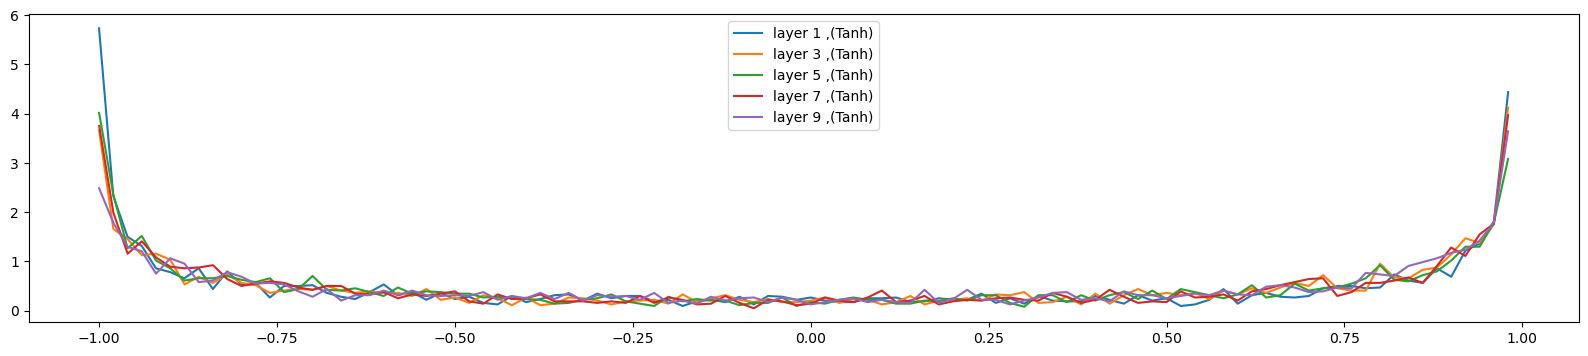

In [117]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t=layer.out
        print("layer %d class name %s : mean:%.2f :std: %.2f and saturated:%.2f"%(i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ,({layer.__class__.__name__})')
plt.legend(legends)
plt.plot()

layer 1 class name Tanh : mean:+0.000072 :std: 0.003921 and saturated:0.000000
layer 3 class name Tanh : mean:-0.000059 :std: 0.003831 and saturated:0.000000
layer 5 class name Tanh : mean:+0.000117 :std: 0.003686 and saturated:0.000000
layer 7 class name Tanh : mean:+0.000107 :std: 0.003776 and saturated:0.000000
layer 9 class name Tanh : mean:-0.000039 :std: 0.003409 and saturated:0.000000


[]

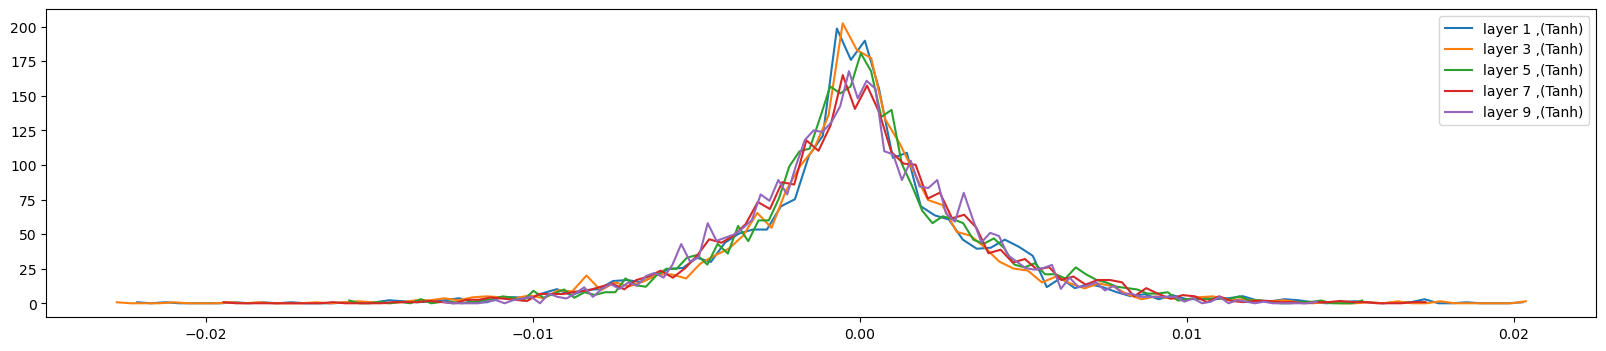

In [118]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t=layer.out.grad
        print("layer %d class name %s : mean:%+f :std: %f and saturated:%.2f%"%(i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ,({layer.__class__.__name__})')
plt.legend(legends)
plt.plot()

weight   (27, 10) | mean -0.000561 |std 1.297199e-02 |grad:data ratio 1.380547e-02
weight  (30, 100) | mean -0.000408 |std 1.151204e-02 |grad:data ratio 3.633863e-02
weight (100, 100) | mean +0.000026 |std 8.931895e-03 |grad:data ratio 5.084951e-02
weight (100, 100) | mean +0.000014 |std 8.405618e-03 |grad:data ratio 4.770225e-02
weight (100, 100) | mean -0.000105 |std 7.826990e-03 |grad:data ratio 4.506739e-02
weight (100, 100) | mean +0.000086 |std 7.247655e-03 |grad:data ratio 4.189515e-02
weight  (100, 27) | mean +0.000000 |std 2.095207e-02 |grad:data ratio 1.802231e-01


Text(0.5, 1.0, 'gradient to data ratio')

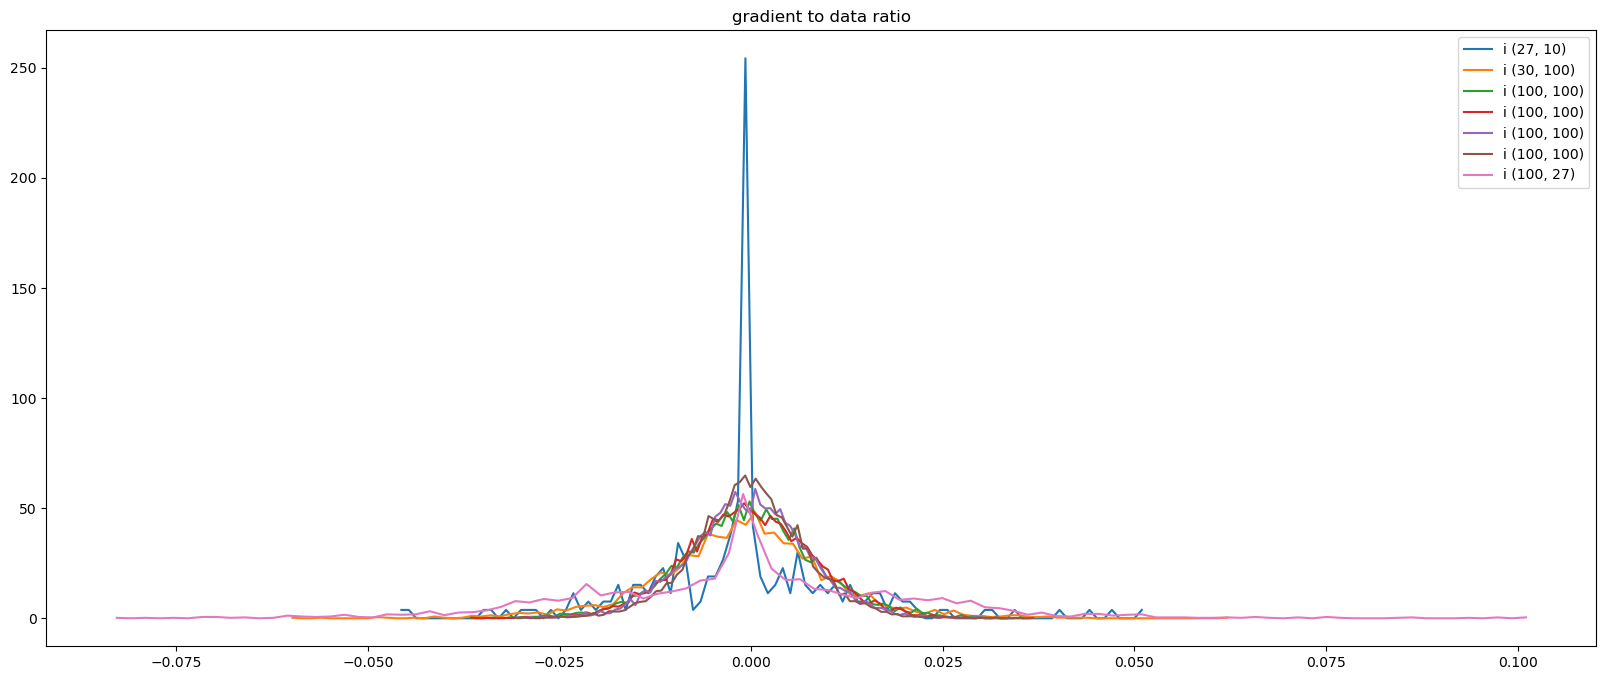

In [119]:
# lets visualize the data to gradient ratio
plt.figure(figsize=(20,8))
legends=[]
for i,p in enumerate(parameters):
    t=p.grad
    if p.ndim==2:
        print("weight %10s | mean %+f |std %e |grad:data ratio %e" % (tuple(p.shape),t.mean(),t.std(),t.std()/p.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'i {tuple(p.shape)}')
plt.legend(legends);
plt.title("gradient to data ratio")

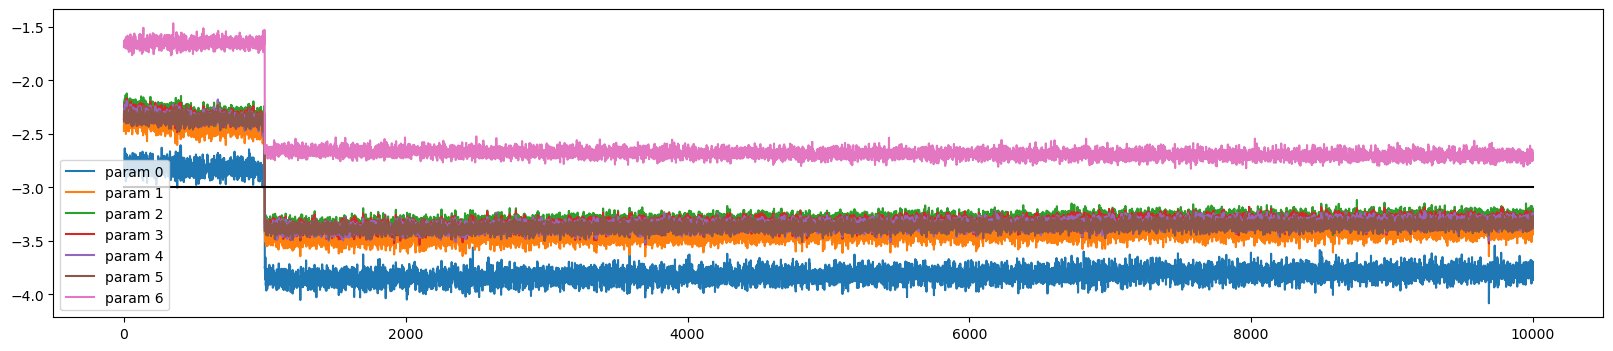

In [120]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: #we are focusing only on weight of the NN
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.legend(legends);
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot

# lets see what heppens when we add batch normalization to it

In [211]:
C=torch.randn((vocab_size,emb_size),generator=g)
layers=[
    Linear(block_size*emb_size,n_hidden,bias=False),Tanh(), # this is the frst layer in MLP
    Linear(n_hidden,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),BatchNorm(vocab_size)
]

with torch.no_grad():
    #layers[-1].weight*=0.1  # adjustment in the last layer
    layers[-1].gamma*=0.1
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight*=5/3  # weight initialization for the rest of the layers
        
parameters=[C]+[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True

46851


In [ ]:
# the training and optimization
batch_size=32
max_steps=2000
lossi=[]
ud=[]

for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,),generator=g)
    xb,yb=xtr[ix],ytr[ix]
    # the feed forward 
    emb=C[xb]
    x=emb.view(emb.shape[0],-1)
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x,yb)
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    
    for p in parameters:
        p.grad=None
        
    loss.backward()
    #update the weights
    lr=1 #if i<1000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    if i%1000 == 0:
        print(f"the iteration {i:d} loss: {loss:.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std()/p.data.std()).log10().item() for p in parameters])
    if i>=10000:
        break;

the iteration 0 loss: 3.3193


In [ ]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t=layer.out
        print("layer %d class name %s : mean:%.2f :std: %.2f and saturated:%.2f%%"%(i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ,({layer.__class__.__name__})')
plt.legend(legends)
plt.plot()

In [ ]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t=layer.out.grad
        print("layer %d class name %s : mean:%+f :std: %f and saturated:%f"%(i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ,({layer.__class__.__name__})')
plt.legend(legends)
plt.plot()

In [ ]:
# lets visualize the data to gradient ratio
plt.figure(figsize=(20,8))
legends=[]
for i,p in enumerate(parameters):
    t=p.grad
    if p.ndim==2:
        print("weight %10s | mean %+f |std %e |grad:data ratio %e" % (tuple(p.shape),t.mean(),t.std(),t.std()/p.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'i {tuple(p.shape)}')
plt.legend(legends);
plt.title("gradient to data ratio")

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: #we are focusing only on weight of the NN
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.legend(legends);
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot

In [ ]:
# lets check for loss on the train and validation set
@torch.no_grad()
def split_loss(split):
    
    x,y={
        "train":(xtr,ytr),
        "valid":(xval,yval),
        "test":(xtest,ytest)
    }[split]
    emb=C[x] 
    x=emb.view(emb.shape[0],-1)
    for layer in layers:
       x=layer(x)
    loss=F.cross_entropy(x,y)
    print(split,loss)

for layer in layers:
    layer.training=False

split_loss("train")
split_loss("valid")

# lets generate names using this model YAY

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out=[]
    context=[0]*block_size
    while True:
        #the feed forward pass
        emb=C[torch.tensor([context])]
        x=emb.view(emb.shape[0],-1)
        for layer in layers:
            x=layer(x)
        logits=x
        probs=F.softmax(logits,dim=1)
        xi=torch.multinomial(probs,num_samples=1,generator=g).item()
        context=context[1:]+[xi]
        out.append(xi)
        if xi==0:
            break
        print("".join(itos[i] for i in out))